In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)
from imblearn.over_sampling import RandomOverSampler

# modelos de machine learning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Fórmulas e arquivos auxiliares
from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models_imblearn import RANDOM_STATE
from src.models_imblearn import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
    metricas_grid_search
)

# Para exportar o modelo
from joblib import dump
from src.config import MODELO_FINAL_2

sns.set_theme(palette="bright")

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int8  
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int16 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int8  
 6   Education                 1470 non-null   int8  
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int8  
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int8  
 11  JobInvolvement            1470 non-null   int8  
 12  JobLevel                  1470 non-null   int8  
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

#### Separação das colunas da Análise Exploratória

In [4]:
colunas_categoricas_nao_ordenadas = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]

colunas_categoricas_ordenadas = [
    "Education",
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
]

coluna_alvo = ["Attrition"]

colunas_numericas = [
    coluna for coluna in df.columns if coluna not in (
        colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas + coluna_alvo
    )
]

colunas_numericas

['Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

#### Separação das colunas numéricas de acordo com a transformação que vão passar

In [5]:
colunas_numericas_min_max = [                                             # Sâo colunas que parecem ter uma distribuição uniforme
    "DailyRate",
    "HourlyRate",
    "MonthlyRate",
]

colunas_numericas_std = ["Age",]                                          # Já possui distribuição normal, vamos usar o StandardScaler

colunas_numericas_power_transform = [                                     # Colunas numéricas que possui distribuição assimétrica (nem uniforme e nem normal)
    coluna for coluna in colunas_numericas if coluna not in (
        colunas_numericas_min_max + colunas_numericas_std
    )
]

colunas_numericas_power_transform

['DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [6]:
X = df.drop(columns=coluna_alvo)
y = df[coluna_alvo]

In [7]:
y[:5]

,Attrition
0,Yes
1,No
2,Yes
3,No
4,No


In [8]:
y.values

array([['Yes'],
       ['No'],
       ['Yes'],
       ...,
       ['No'],
       ['No'],
       ['No']], dtype=object)

#### Tranformando coluna do target para numérica

In [9]:
le = LabelEncoder()

y = le.fit_transform(y)

y[:10]

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [10]:
le.classes_

array(['No', 'Yes'], dtype=object)

#### Definindo os Folds para validação cruzada

In [11]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#### Definindo Preprocessamento

In [12]:
preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ('ordinal', OrdinalEncoder(categories='auto'), colunas_categoricas_ordenadas)
    ]
)

preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ('ordinal', OrdinalEncoder(categories='auto'), colunas_categoricas_ordenadas),
        ('min_max', MinMaxScaler(), colunas_numericas_min_max),
        ('stdscaler', StandardScaler(), colunas_numericas_std),
        ('power_transform', PowerTransformer(), colunas_numericas_power_transform),
    ]
)

#### Definindo Método de Balanceamento dos Dados

In [13]:
sampler = RandomOverSampler(random_state=RANDOM_STATE)

#### Dicionário de Classificadores

- *Balanceamento das classes*: Para esse notebook adaptei criei o arquivo "models_imblearn.py" para que a função "treinar_e_validar_modelo_classificacao" receba externamente o modelo de balanceamento de classes que definirmos como mais adequado.

In [14]:
classificadores = {
    'DummyClassifier': {
        'classificador' : DummyClassifier(),
        'preprocessor' : None,
        'sampler': None
    },

    # modelos lineares
    'LogisticRegression': {
        'classificador' : LogisticRegression(random_state=RANDOM_STATE),
        'preprocessor' : preprocessamento,
        'sampler': sampler
    },

    # modelos de árvore de decisão
    'DecisionTree': {
        'classificador' : DecisionTreeClassifier(random_state=RANDOM_STATE),
        'preprocessor' : preprocessamento_arvore,
        'sampler': sampler
    },
    'LightGBM': {                                                                        
        'classificador' : LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),    
        'preprocessor' : preprocessamento_arvore,
        'sampler': sampler
    },       
    'XGBoost': {
        'classificador' : XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'preprocessor' : preprocessamento_arvore,
        'sampler': sampler
    },   

    #kNN
    'KNeighboursClassifier': {
        'classificador' : KNeighborsClassifier(),
        'preprocessor' : preprocessamento,
        'sampler': sampler
    },

    #SVC
    'SVC': {
        'classificador' : SVC(random_state=RANDOM_STATE), 
        'preprocessor' : preprocessamento,
        'sampler': sampler
    },   
}

#### Treinando e Testando Modelos de Classificação

In [15]:
resultados = {nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **modelo) 
              for nome_modelo, modelo in classificadores.items()}

df_resultados = organiza_resultados(resultados)

df_resultados

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.00299,0.020259,0.836735,0.5,0.0,0.0,0.0,0.5,0.163265,0.023249
1,DummyClassifier,0.002242,0.017952,0.836735,0.5,0.0,0.0,0.0,0.5,0.163265,0.020194
2,DummyClassifier,0.001899,0.013963,0.840136,0.5,0.0,0.0,0.0,0.5,0.159864,0.015862
3,DummyClassifier,0.001897,0.01895,0.840136,0.5,0.0,0.0,0.0,0.5,0.159864,0.020847
4,DummyClassifier,0.002001,0.021557,0.840136,0.5,0.0,0.0,0.0,0.5,0.159864,0.023558
5,LogisticRegression,0.085358,0.033712,0.707483,0.724593,0.455696,0.327273,0.75,0.798103,0.548634,0.11907
6,LogisticRegression,0.07005,0.031523,0.768707,0.744411,0.5,0.386364,0.708333,0.825373,0.565305,0.101573
7,LogisticRegression,0.068531,0.028557,0.72449,0.749892,0.477419,0.342593,0.787234,0.846326,0.65278,0.097088
8,LogisticRegression,0.083379,0.033385,0.751701,0.748859,0.48951,0.364583,0.744681,0.834783,0.608646,0.116764
9,LogisticRegression,0.067978,0.031893,0.758503,0.735679,0.481752,0.366667,0.702128,0.776036,0.572919,0.099871


**Qual métrica vamos escolher para a melhor para esse contexto?**
- Queremos saber o que levo os funcionários a sair da empresa (Attrition)
- Também é importante querer saber o que faz os funcionários ficarem na empresa
- Ou seja, podemos usar uma métrica que faça o balanceamento entre precision e recall
- Logo, vamos o usar o average_precision (poderíamos usar o f1 também)

In [16]:
df_resultados.groupby(by='model').mean().sort_values(by='test_average_precision', ascending=True)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.002206,0.018536,0.838776,0.5,0.0,0.0,0.0,0.5,0.161224,0.020742
DecisionTree,0.019346,0.028593,0.67619,0.662293,0.388626,0.279254,0.641667,0.662293,0.238438,0.047939
KNeighboursClassifier,0.047996,0.079488,0.730612,0.665559,0.405845,0.31686,0.569592,0.728196,0.355607,0.127484
XGBoost,0.060006,0.037535,0.714286,0.700185,0.434119,0.319391,0.679344,0.773475,0.444256,0.097541
LightGBM,0.110119,0.044594,0.72381,0.715876,0.451201,0.33224,0.704255,0.79084,0.482381,0.154713
LogisticRegression,0.075059,0.031814,0.742177,0.740687,0.480876,0.357496,0.738475,0.816124,0.589657,0.106873
SVC,0.06368,0.062532,0.765306,0.747714,0.500218,0.383697,0.72172,0.826207,0.61304,0.126212


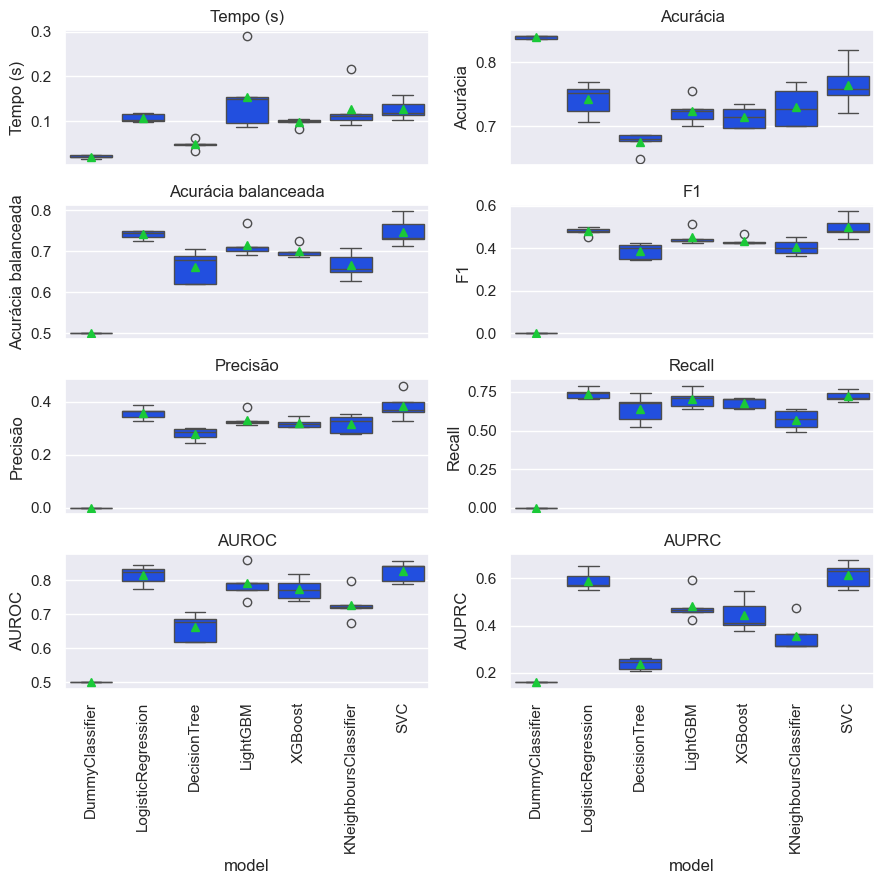

In [17]:
plot_comparar_metricas_modelos(df_resultados)

Veja que os melhores modelos continuam sendo o LogisticRegression e o SVC, com uma ligeira vantagem pro SVC agora com o RandomUnderSampler e RandomOverSampler

#### Escolher modelo para otimização: *LogisticRegression*
- Os melhores modelos foram LogisticRegression e SVC
- Mas o SVC é mais lento, possui interpretação mais complexa e recall menor quando comparado com LogisticRegression
- Podemos fazer um segundo grid_search usando o SVC para comparar os resultados dos 2 modelos otimizados caso acharmos necessário posteriormente.

#### Testando diferentes parâmetros no melhor modelo

In [18]:
param_grid = {
    'clf__penalty': ['l1', 'l2', 'elasticnet', None],                # Regularização
    'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1],                        # Apenas se o modelo for elastic_net
    'clf__C': [0.01, 0.1, 1, 10],    
    'clf__solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    #'clf__class_weight': [None, 'balanced']                         # Podemos tirar do grid_search e já deixar dentro do modelo, será uma variável a menos pra ser analisada
}

#### Rodando a função do GridSearchCV

In [19]:
clf = LogisticRegression(random_state=RANDOM_STATE) #, class_weight='balanced')

grid_search = grid_search_cv_classificador(
    clf,
    param_grid=param_grid,
    cv=kf,
    preprocessor=preprocessamento,
    refit_metric='average_precision'
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None],
                         'clf__solver': ['liblinear', 'saga', 'lbfgs',
                                         'newton-cg']},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [20]:
grid_search.fit(X,y)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
600 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\brcprrcchave\AppData\Local\anaconda

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10],
                         'clf__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None],
                         'clf__solver': ['liblinear', 'saga', 'lbfgs',
                                         'newton-cg']},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [21]:
grid_search.best_score_            

0.6545031481317757

**Análise do best_score_**: 
- Aumentou de 0.58 no modelo simples do LogisticRegression para 0.65. 
- Com o class_weight='balanced' e sem RandomUnderSampler era 0.634, 
- Com RandomUnderSampling foi de 0.617, 
- Melhor resultado foi obtido com o método de RandomOverSampler para balanceamento dos dados.
- Poderíamos testar o modelo SVC com otimização de parametros para ver se os resultados seriam ainda melhores.

In [22]:
grid_search.best_params_

{'clf__C': 0.1,
 'clf__l1_ratio': 0.25,
 'clf__penalty': 'elasticnet',
 'clf__solver': 'saga'}

**OBS:** Veja que tivemos penalty='elasticnet' indicando que houve sim regularização do modelo, ou seja, algumas features do modelo tiveram seu coeficiente zerado.

#### Obtendo as Outras Métricas do grid_search.best_estimator

In [23]:
grid_search.cv_results_        # Para ver o resultado de TODAS AS MÉTRICAS de TODOS MODELOS formados com o GRID_SEARCH

{'mean_fit_time': array([0.13616695, 0.12712841, 0.13826742, 0.1300097 , 0.11863103,
        0.16733761, 0.14214115, 0.11849937, 0.11286197, 0.18606615,
        0.12404127, 0.13941398, 0.1350781 , 0.27550936, 0.17783647,
        0.22914257, 0.1344954 , 0.16208076, 0.13543339, 0.11411347,
        0.11672058, 0.2277215 , 0.16026354, 0.15167546, 0.12674103,
        0.20235152, 0.13238611, 0.12116742, 0.15179715, 0.27297173,
        0.17265959, 0.23065696, 0.13110771, 0.12914915, 0.11881137,
        0.13204379, 0.12414942, 0.16270032, 0.11225944, 0.13632827,
        0.10923052, 0.14601154, 0.13771529, 0.12499013, 0.10753627,
        0.24514484, 0.14056306, 0.19612808, 0.11850977, 0.12188091,
        0.09900026, 0.10144587, 0.10960484, 0.15667772, 0.10503974,
        0.11720839, 0.10203714, 0.12795229, 0.10286531, 0.10289574,
        0.1014822 , 0.24934306, 0.13233576, 0.18243709, 0.10991602,
        0.11650109, 0.11299896, 0.10551872, 0.10681009, 0.17755165,
        0.13178782, 0.1176301 ,

In [24]:
grid_search.cv_results_.keys()     

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__C', 'param_clf__l1_ratio', 'param_clf__penalty', 'param_clf__solver', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_tes

In [25]:
metricas = []

for metrica in grid_search.cv_results_.keys():
    if metrica.startswith('mean'):
        metricas.append(metrica)

metricas

['mean_fit_time',
 'mean_score_time',
 'mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [26]:
grid_search.best_index_         # O melhor modelo de todos do grid_search foi o de índice 105

105

In [27]:
grid_search.cv_results_['mean_test_average_precision']

array([0.33204142, 0.16122449,        nan,        nan, 0.59403612,
       0.59712737, 0.59698454, 0.5971215 ,        nan, 0.59712737,
              nan,        nan,        nan, 0.6417688 , 0.63936469,
       0.64034763, 0.33204142, 0.16122449,        nan,        nan,
       0.59403612, 0.59712737, 0.59698454, 0.5971215 ,        nan,
       0.4974089 ,        nan,        nan,        nan, 0.6417688 ,
       0.63936469, 0.64034763, 0.33204142, 0.16122449,        nan,
              nan, 0.59403612, 0.59712737, 0.59698454, 0.5971215 ,
              nan, 0.34030981,        nan,        nan,        nan,
       0.6417688 , 0.63936469, 0.64034763, 0.33204142, 0.16122449,
              nan,        nan, 0.59403612, 0.59712737, 0.59698454,
       0.5971215 ,        nan, 0.31181554,        nan,        nan,
              nan, 0.6417688 , 0.63936469, 0.64034763, 0.33204142,
       0.16122449,        nan,        nan, 0.59403612, 0.59712737,
       0.59698454, 0.5971215 ,        nan, 0.16122449,        

In [28]:
grid_search.cv_results_['mean_test_average_precision'][grid_search.best_index_]      # Veja que é o mesmo score obtido pelo grid_search.best_score_

0.6545031481317757

In [29]:
coluna_test = [coluna for coluna in df_resultados.columns if coluna.startswith('test')]
coluna_test

['test_accuracy',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision']

In [30]:
colunas_test_mean = ['mean_' + coluna for coluna in coluna_test]
colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [31]:
for coluna in colunas_test_mean:
    print(f'{coluna}: {grid_search.cv_results_[coluna][grid_search.best_index_]}')

mean_test_accuracy: 0.8843537414965986
mean_test_balanced_accuracy: 0.6618428187199866
mean_test_f1: 0.48166790680030924
mean_test_precision: 0.8734502923976608
mean_test_recall: 0.33342198581560284
mean_test_roc_auc: 0.8296029798042402
mean_test_average_precision: 0.6545031481317757


In [32]:
metricas_grid_search(grid_search)

mean_fit_time: 0.2138063430786133
mean_score_time: 0.08521723747253418
mean_test_accuracy: 0.8843537414965986
mean_test_balanced_accuracy: 0.6618428187199866
mean_test_f1: 0.48166790680030924
mean_test_precision: 0.8734502923976608
mean_test_recall: 0.33342198581560284
mean_test_roc_auc: 0.8296029798042402
mean_test_average_precision: 0.6545031481317757


#### Analisando coeficientes das features de maior importância pro modelo

In [33]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_['clf'].coef_[0],
    grid_search.best_estimator_['preprocessor'].get_feature_names_out()
)

coefs

,coeficiente
ordinal__JobInvolvement,-0.441912
power_transform__MonthlyIncome,-0.397364
one_hot__Department_Research & Development,-0.353522
ordinal__EnvironmentSatisfaction,-0.338961
ordinal__JobSatisfaction,-0.319471
power_transform__TotalWorkingYears,-0.296035
ordinal__StockOptionLevel,-0.266355
ordinal__WorkLifeBalance,-0.244953
power_transform__TrainingTimesLastYear,-0.193692
power_transform__YearsInCurrentRole,-0.192178


- Podemos perceber que tem alguns coeficientes zerados (foi obtido devido parametros de regularização), e indica algumas informações que não fazem diferença pro Attrition.
- Posso voltar pra análise exploratória pra deixar o projeto mais detalhado, já sabendo quais features que não devo me preocupar em maior detalhamento, pois não influencia o Attrition.

In [34]:
coefs.query('coeficiente == 0')

,coeficiente
ordinal__PerformanceRating,0.0
ordinal__JobLevel,0.0
min_max__HourlyRate,0.0
min_max__MonthlyRate,0.0
one_hot__MaritalStatus_Married,0.0
one_hot__JobRole_Sales Executive,0.0
one_hot__EducationField_Other,0.0
one_hot__JobRole_Manufacturing Director,0.0
one_hot__JobRole_Manager,0.0
one_hot__JobRole_Human Resources,0.0


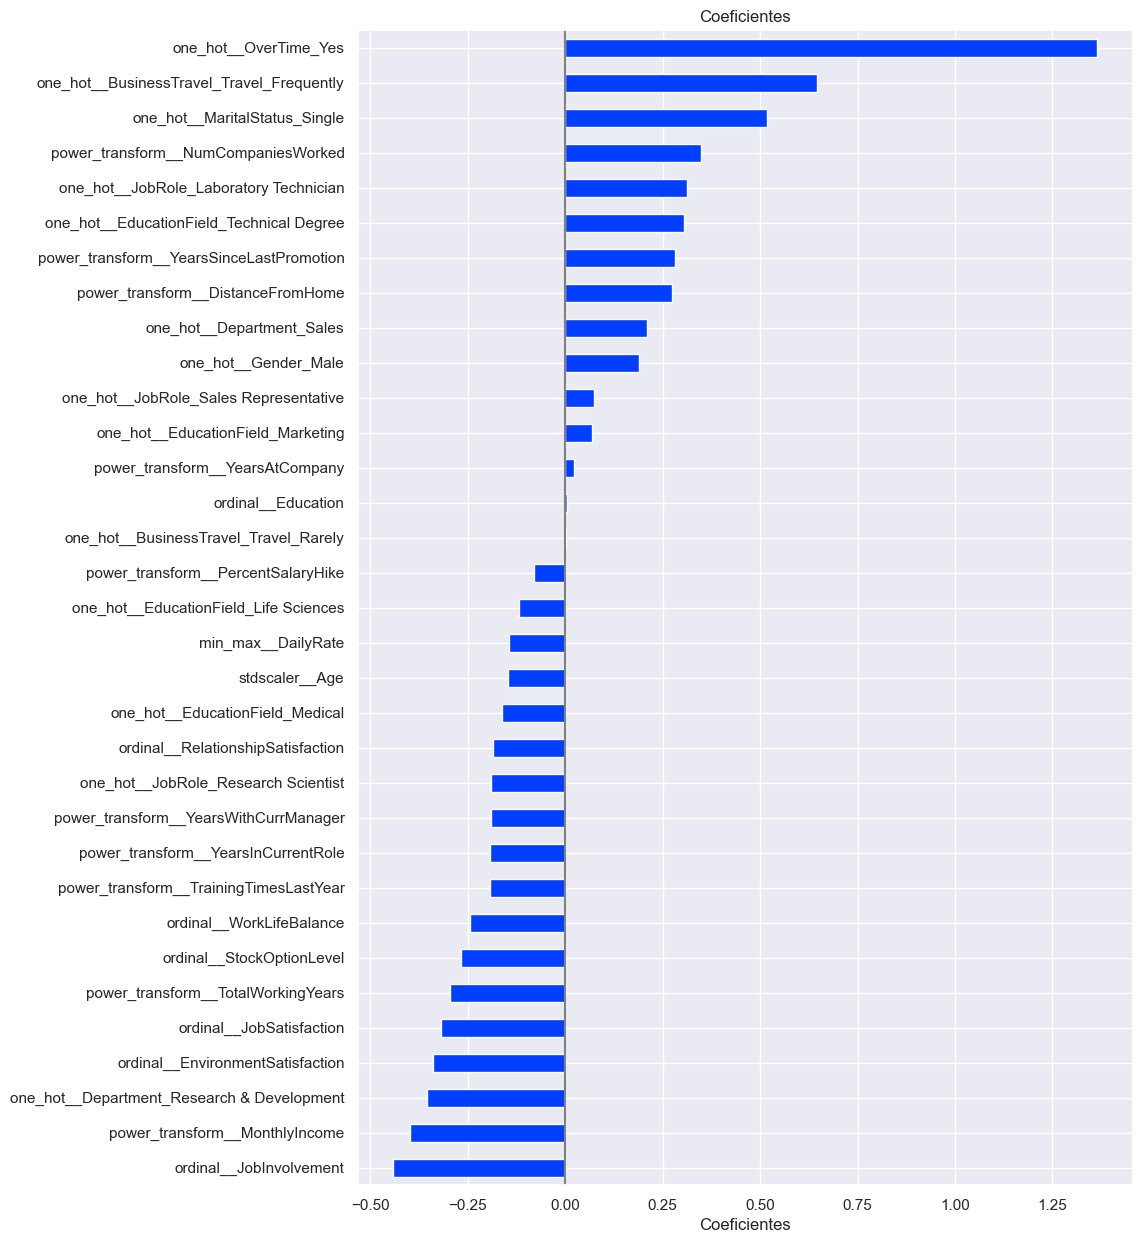

In [35]:
plot_coeficientes(coefs.query('coeficiente !=0'))

**Observações - Correlação não explica causalidade**

- Por exemplo, temos um maior % de Attrition em "solteiros", mas o fato de ser solteiro não quer dizer que as pessoas vão sair da empresa (só que talvez os casados tenham menor probabilidade pois existe a suposição de que podem ter família pra cuidar).

- Podemos destacar sim que Horas Extras e Viagem Frequente tem maior correlação (e não causalidade) com o Attrition.


#### <font color = 'darkblue'> **Transformando os coeficientes de uma regressão logística numa Probabilidade da feature influenciar o target**

##### **Explicação dos Coeficientes de uma Regressão Logística**

Os coeficientes $w_i$ em uma regressão logística não são interpretados diretamente como em uma regressão linear. Em vez disso, eles representam o **logaritmo do odds ratio** associado a cada variável.

- **Odds (Chances):** Razão entre a probabilidade do evento ocorrer e a probabilidade de não ocorrer.

  $$
  \text{Odds} = \frac{\text{Probabilidade do Evento}}{1 - \text{Probabilidade do Evento}}
  $$

- **Odds Ratio:** Medida de quanto as chances mudam com uma unidade de aumento na variável independente.

- **Coeficiente ($w_i$):** Representa a mudança nos **log-odds** do resultado por unidade de aumento na variável $X_i$.

  $$
  \text{Log-Odds} = w_0 + w_1X_1 + w_2X_2 + \dots + w_nX_n
  $$

Para interpretar os coeficientes em termos mais intuitivos, podemos calcular o **exponencial do coeficiente**:

$$
\text{Odds Ratio} = e^{w_i}
$$

- **Interpretação do Odds Ratio:**
  - **Valor > 1:** Aumenta as chances do evento ocorrer.
  - **Valor = 1:** Não afeta as chances.
  - **Valor < 1:** Diminui as chances do evento ocorrer.


Imagine que estamos modelando a probabilidade de um paciente ter uma doença com base na idade e no hábito de fumar.

$$
\text{Log-Odds} = w_0 + w_1 (\text{Idade}) + w_2 (\text{Fumante})
$$

Suponha que obtivemos os seguintes coeficientes:

- $w_0 = -2$
- $w_1 = 0{,}05$
- $w_2 = 1{,}5$

1. **Coeficiente da Idade ($w_1 = 0{,}05$, variável contínua):**

   - **Log-Odds:** Para cada aumento de 1 ano na idade, o log-odds de ter a doença aumenta em 0,05.
   - **Odds Ratio:** $e^{0{,}05} \approx 1{,}051$
   - **Interpretação:** Cada ano adicional de idade aumenta as chances de ter a doença em aproximadamente **5,1%**.

2. **Coeficiente do Fumante ($w_2 = 1{,}5$, variável categórica):**

   - **Log-Odds:** Se o paciente é fumante (1), o log-odds de ter a doença aumenta em 1,5 em comparação com não fumantes (0).
   - **Odds Ratio:** $e^{1{,}5} \approx 4{,}48$
   - **Interpretação:** Fumantes têm **4,48 vezes** mais chances de ter a doença do que não fumantes.


In [36]:
coefs_odds = coefs.copy()

coefs_odds['coeficiente'] = np.exp(coefs_odds['coeficiente'])

coefs_odds

,coeficiente
ordinal__JobInvolvement,0.642806
power_transform__MonthlyIncome,0.672089
one_hot__Department_Research & Development,0.702211
ordinal__EnvironmentSatisfaction,0.712510
ordinal__JobSatisfaction,0.726533
power_transform__TotalWorkingYears,0.743761
ordinal__StockOptionLevel,0.766167
ordinal__WorkLifeBalance,0.782741
power_transform__TrainingTimesLastYear,0.823912
power_transform__YearsInCurrentRole,0.825160


In [37]:
coefs_odds.query('coeficiente == 1')        

,coeficiente
ordinal__PerformanceRating,1.0
ordinal__JobLevel,1.0
min_max__HourlyRate,1.0
min_max__MonthlyRate,1.0
one_hot__MaritalStatus_Married,1.0
one_hot__JobRole_Sales Executive,1.0
one_hot__EducationField_Other,1.0
one_hot__JobRole_Manufacturing Director,1.0
one_hot__JobRole_Manager,1.0
one_hot__JobRole_Human Resources,1.0


OBS: Esses coefs_odds igual a 1 são aqueles cujo coef eram igual a 0 (ou seja, nem aumentam e nem diminuem a chance de mudar o target)

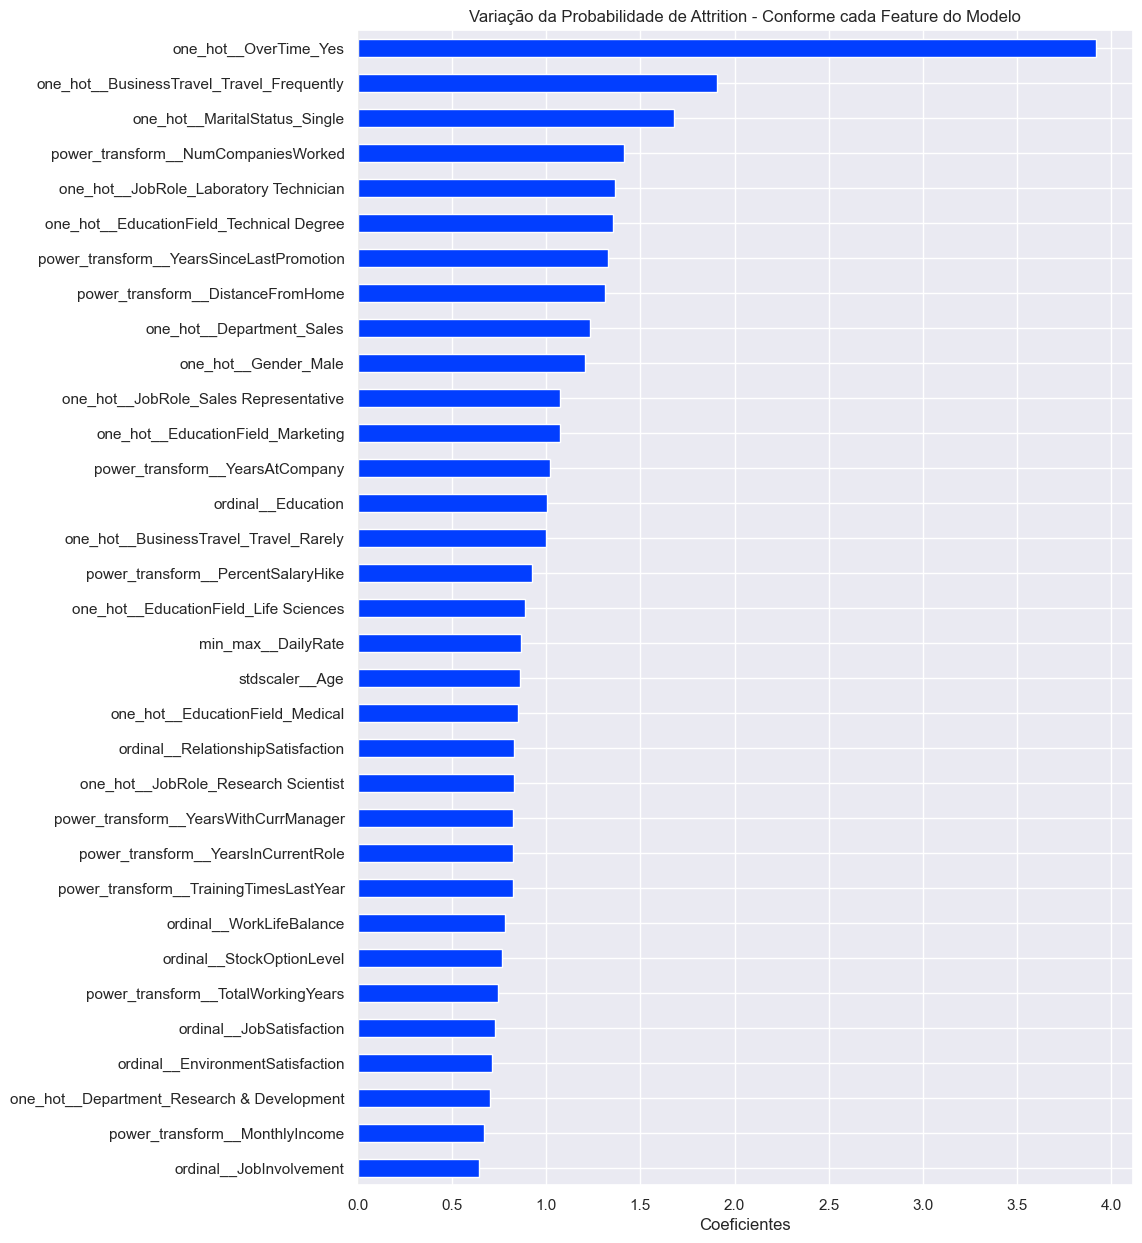

In [38]:
plot_coeficientes(
    coefs_odds.query('coeficiente != 1'),
    "Variação da Probabilidade de Attrition - Conforme cada Feature do Modelo"
)

##### **Conclusões**
- Podemos ver que os funcionários que fazem hora extra tem 2.5 vezes mais chances de deixar a empresa
- Funcionários que fazem viagens a trabalho tem 1.6 vezes mais chances de deixar a empresa também.
- Funcionários que são solteiros tendem a ter maior probabilidade de sair da empresa quando comparado com funcionários casados (correlação não indica causalidade nesse caso, é só um dado observado)
- Já features relacionadas à satisfação e envolvimento do funcionário na empresa / cargo ajudam a manter os funcionários, assim como o maior renda mensal e a quantidade de anos trabalhando na empresa / cargo.

- *Houve pequenas mudanças no coeficiente % das features mudando de "class_weight='balanced'" para um método de RandomUnderSampler, mas nada tão significativo. As principais features continuam sendo as mesmas.*

#### Matriz de Confusão

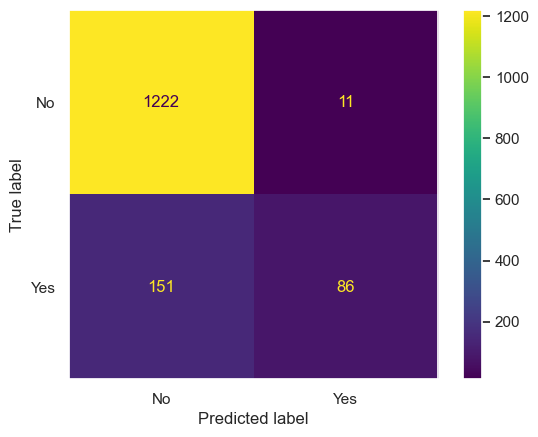

In [39]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels = le.classes_
)

plt.grid(False)
plt.show()

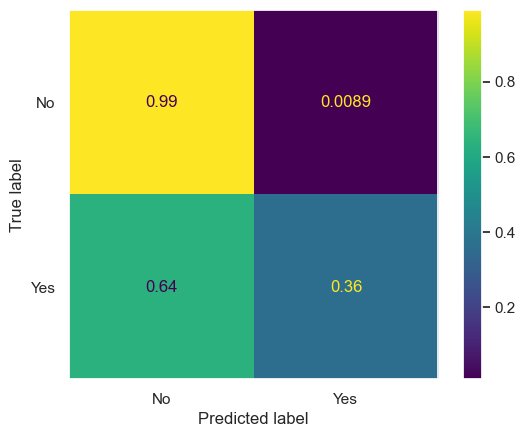

In [40]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels = le.classes_,
    normalize='true'
)

plt.grid(False)
plt.show()

#### Explicando como obter a probabilidade do funcionário sair da empresa

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = RANDOM_STATE, stratify=y
)

grid_search.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Education',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'JobInvolvement', 'JobLevel',
                                                   'PerformanceRating',
                                                   'RelationshipSatis...
                                                 ('power_transform',
                                                  PowerTransformer(),
                                                  ['DistanceFromHome',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('clf',
                 LogisticRegression(C=0.1, l1_ratio=0.25, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [43]:
y_pred = grid_search.best_estimator_.predict(X_test)

y_pred[:10]              # É o predict com as classes 0 e 1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [44]:
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)

y_pred_proba[:10]        # É o predict com as probabilidades de pertencer às classes 0 e 1

array([[0.71495512, 0.28504488],
       [0.98908173, 0.01091827],
       [0.89170866, 0.10829134],
       [0.99551605, 0.00448395],
       [0.73401955, 0.26598045],
       [0.77219977, 0.22780023],
       [0.97777775, 0.02222225],
       [0.9602463 , 0.0397537 ],
       [0.98653355, 0.01346645],
       [0.5251684 , 0.4748316 ]])

A probabilidade do funcionário sair da empresa vai ser sempre o segundo valor da lista acima. É esse valor que vamos mostrar no Streamlit que receberá o modelo (probabilidade de saída do funcionário da empresa - Attrition).

#### **Exportando o modelo**
-FUNÇÃO: dump(modelo, "diretório_windows")

In [45]:
dump(grid_search.best_estimator_, MODELO_FINAL_2)

['C:\\Users\\brcprrcchave\\OneDrive - Blount\\Documents\\Treinamentos & Cursos\\Ciência dos Dados Impressionador - Hashtag\\Mod 22 - Projeto - IBM Attrition\\modelos\\logistic_regression_ros.joblib']

#### **Plano de Ação**

- Avaliar os motivos que levam os funcionários a fazerem hora extra que podem influenciar no Attrition
    - Mão de obra insuficiente
    - Falta de organização institucional
    - Falta de treinamento
    - Necessidade de investimento em tecnologia
- Existe a possibilidade de diminuir ou limitar as viagens de negócios?
    - Como isso pode afetar alguns departamentos (ex: vendas)?
    - O que pode tornar as viagens de negócio um motivo para saída da empresa?
- Como a renda mensal de cada setor em nível da empresa se compara ao mercado?
- Quais as ações a empresa pode promover para aumentar o envolvimento e a satisfação do funcionários? Principalmente nos departamentos com maior probabilidade de Attrition 

**OBS**: Analisar as features que mais influenciam o modelo. Destacar features com relação positivas e negativas no estudo feito, ou pro resultado do projeto.

**GITHUB**: Destacar esse plano de ação no GitHub, sintetizando informações importantes do modelo e propondo ações, em algum arquivo / relatório como README, Conclusões, Plano_acao.txt, ou até numa apresentação de PowerPoint do projeto.